<a href="https://colab.research.google.com/github/manishadeepa/smartwriting-pen-and-pad/blob/main/handwriting_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cite for EMNIST dataset:

Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373

In [1]:
import tensorflow as tf
import numpy as np
import scipy.io
import zipfile
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

In [3]:
# Paths
zip_path = '/content/drive/MyDrive/matlab.zip'
extract_path = '/content/emnist'

# Extract zip file
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Load EMNIST balanced dataset
mat_path = os.path.join(extract_path, 'matlab/emnist-balanced.mat')
mat = scipy.io.loadmat(mat_path)

# Extract data
x_train = mat['dataset']['train'][0][0]['images'][0][0]
y_train = mat['dataset']['train'][0][0]['labels'][0][0].flatten()
x_test = mat['dataset']['test'][0][0]['images'][0][0]
y_test = mat['dataset']['test'][0][0]['labels'][0][0].flatten()

In [4]:
from tensorflow.keras.utils import to_categorical
import numpy as np

def preprocess_data(x, y, num_classes=47):
    # Ensure x is normalized and reshaped
    x = x.astype('float32') / 255.0
    x = x.reshape(-1, 28, 28, 1)
    # Ensure y is integer labels, then one-hot encode
    y = y.astype('int32').flatten()  # Flatten to ensure 1D array of integers
    y = to_categorical(y, num_classes)
    return x, y  # Fixed typo

# Assuming mat is loaded from earlier
x_train = mat['dataset']['train'][0][0]['images'][0][0]
y_train = mat['dataset']['train'][0][0]['labels'][0][0]
x_test = mat['dataset']['test'][0][0]['images'][0][0]
y_test = mat['dataset']['test'][0][0]['labels'][0][0]

# Apply preprocessing
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

# Create validation set
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Debug shapes and types
print(f"x_train dtype: {x_train.dtype}, shape: {x_train.shape}")
print(f"y_train dtype: {y_train.dtype}, shape: {y_train.shape}")
print(f"x_val dtype: {x_val.dtype}, shape: {x_val.shape}")
print(f"y_val dtype: {y_val.dtype}, shape: {y_val.shape}")
print(f"x_test dtype: {x_test.dtype}, shape: {x_test.shape}")
print(f"y_test dtype: {y_test.dtype}, shape: {y_test.shape}")

x_train dtype: float32, shape: (90240, 28, 28, 1)
y_train dtype: float64, shape: (90240, 47)
x_val dtype: float32, shape: (22560, 28, 28, 1)
y_val dtype: float64, shape: (22560, 47)
x_test dtype: float32, shape: (18800, 28, 28, 1)
y_test dtype: float64, shape: (18800, 47)


In [5]:
def build_model(num_classes=47):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Initialize and compile
model = build_model()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │        24,111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,698,063 (6.48 MB)

 Trainable params: 1,696,655 (6.47 MB)

 Non-trainable params: 1,408 (5.50 KB)

 # Debug initial types
    tf.print("Initial image dtype:", image.dtype, "shape:", tf.shape(image))
    tf.print("Initial label dtype:", label.dtype, "shape:", tf.shape(label))
    
    tf.print("After rotation image dtype:", image.dtype, "shape:", tf.shape(image))
    

In [6]:
import tensorflow as tf

# Define data augmentation function for tf.data
def augment_image(image, label):
    # Ensure types
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)



    # Random flip
    image = tf.image.random_flip_left_right(image)

    # Random brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random rotation (discrete steps)
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)

    # Skip zoom to avoid Mul op issue
    return image, label

# Create tf.data datasets
batch_size = 128

# Ensure input data types
x_train = tf.cast(x_train, tf.float32)
y_train = tf.cast(y_train, tf.float32)
x_val = tf.cast(x_val, tf.float32)
y_val = tf.cast(y_val, tf.float32)

# Debug input types
print(f"x_train dtype: {x_train.dtype}, shape: {x_train.shape}")
print(f"y_train dtype: {y_train.dtype}, shape: {y_train.shape}")
print(f"x_val dtype: {x_val.dtype}, shape: {x_val.shape}")
print(f"y_val dtype: {y_val.dtype}, shape: {y_val.shape}")

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset
                 .shuffle(buffer_size=10000)
                 .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Debug dataset output
for batch_x, batch_y in train_dataset.take(1):
    print(f"Batch x dtype: {batch_x.dtype}, shape: {batch_x.shape}")
    print(f"Batch y dtype: {batch_y.dtype}, shape: {batch_y.shape}")

# Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Train
epochs = 20

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")


x_train dtype: <dtype: 'float32'>, shape: (90240, 28, 28, 1)
y_train dtype: <dtype: 'float32'>, shape: (90240, 47)
x_val dtype: <dtype: 'float32'>, shape: (22560, 28, 28, 1)
y_val dtype: <dtype: 'float32'>, shape: (22560, 47)
Batch x dtype: <dtype: 'float32'>, shape: (128, 28, 28, 1)
Batch y dtype: <dtype: 'float32'>, shape: (128, 47)
Epoch 1/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 507s 711ms/step - accuracy: 0.2370 - loss: 3.0902 - val_accuracy: 0.5519 - val_loss: 1.4681 - learning_rate: 0.0010
Epoch 2/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 514s 728ms/step - accuracy: 0.5506 - loss: 1.4560 - val_accuracy: 0.6713 - val_loss: 1.0257 - learning_rate: 0.0010
Epoch 3/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 545s 704ms/step - accuracy: 0.6196 - loss: 1.2069 - val_accuracy: 0.6895 - val_loss: 0.9420 - learning_rate: 0.0010
Epoch 4/20
705/705 ━━━━━━━━━━━━━━━━━━━━ 501s 710ms/step - accuracy: 0.6468 - loss: 1.1033 - val_accuracy: 0.7153 - val_loss: 0.8654 - learning_rate: 0.0010
Epoch 5/20
705/705 ━━━━━━━━━━━━━━━━━━━━

In [8]:
#saving the model
model.save('/content/drive/MyDrive/emnist_cnn_optimized.keras')


In [7]:
def stroke_to_image_with_pressure(strokes, canvas_size=128, image_size=28,
                                  min_width=1, max_width=6, background=255):
    """
    Convert strokes with pressure data to an EMNIST-compatible image.

    Args:
        strokes: List of (x, y, pressure) points or list of strokes
        canvas_size: Initial canvas size for precision
        image_size: Final size (28 for EMNIST)
        min_width: Minimum stroke width
        max_width: Maximum stroke width
        background: Background color (255 for white)

    Returns:
        img_array: Processed array for model (1, 28, 28, 1)
        img: PIL Image for visualization
    """
    img = Image.new("L", (canvas_size, canvas_size), color=background)
    draw = ImageDraw.Draw(img)

    # Handle single stroke or multiple strokes
    if not isinstance(strokes[0][0], (list, tuple)):
        strokes = [strokes]

    # Get bounding box
    all_points = [(p[0], p[1]) for stroke in strokes for p in stroke]
    if not all_points:
        min_x, max_x, min_y, max_y = 0, 100, 0, 100
    else:
        min_x, max_x = min(p[0] for p in all_points), max(p[0] for p in all_points)
        min_y, max_y = min(p[1] for p in all_points), max(p[1] for p in all_points)
        width = max_x - min_x
        height = max_y - min_y
        padding = max(width, height) * 0.2
        min_x -= padding
        max_x += padding
        min_y -= padding
        max_y += padding

    # Draw strokes
    for stroke in strokes:
        for i in range(len(stroke) - 1):
            x1, y1, p1 = stroke[i]
            x2, y2, p2 = stroke[i + 1]
            # Scale coordinates
            x1_scaled = (x1 - min_x) / (max_x - min_x) * canvas_size
            y1_scaled = (y1 - min_y) / (max_y - min_y) * canvas_size
            x2_scaled = (x2 - min_x) / (max_x - min_x) * canvas_size
            y2_scaled = (y2 - min_y) / (max_y - min_y) * canvas_size
            # Calculate width based on pressure
            avg_pressure = (p1 + p2) / 2
            width = int(min_width + (max_width - min_width) * avg_pressure)
            draw.line([(x1_scaled, y1_scaled), (x2_scaled, y2_scaled)], fill=0, width=width)

    # Resize and preprocess
    img_array = np.array(img.resize((image_size, image_size), Image.LANCZOS))

    # Apply adaptive thresholding to clean image
    img_array = cv2.adaptiveThreshold(
        img_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # Invert to match EMNIST (white characters, black background)
    img_array = 255 - img_array
    img_array = img_array.astype('float32') / 255.0
    img_array = img_array.reshape(1, image_size, image_size, 1)

    return img_array, img.resize((image_size, image_size), Image.LANCZOS)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step


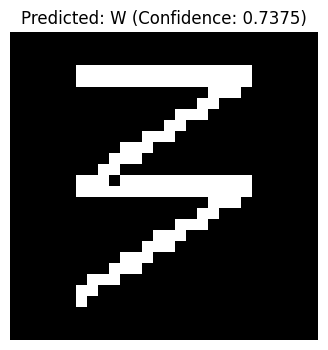

Predicted character: W (Class: 32, Confidence: 0.7375)

Top 3 predictions:
  W: 0.7375
  M: 0.2608
  N: 0.0008


In [50]:
from tensorflow.keras.models import load_model
# Load model
model = load_model('/content/drive/MyDrive/emnist_cnn_optimized.keras')

# Sample stroke data
'''
sample_strokes_A=[[(40, 60, 0.5), (50, 20, 0.5), (60, 60, 0.5), (45, 40, 0.5), (55, 40, 0.5)]]
sample_strokes_D=[[(40, 20, 0.5), (40, 60, 0.5), (50, 60, 0.5), (60, 50, 0.5), (60, 30, 0.5), (50, 20, 0.5), (40, 20, 0.5)]]
sample_strokes_E=[[(60, 20, 0.5), (40, 20, 0.5), (40, 60, 0.5), (60, 60, 0.5), (40, 40, 0.5), (60, 40, 0.5)]]
sample_strokes_I=[[(50, 20, 0.5), (50, 60, 0.5)]]
sample_strokes_K=[[(40, 20, 0.5), (40, 60, 0.5), (60, 40, 0.5), (40, 60, 0.5), (60, 20, 0.5)]]
sample_strokes_L=[[(40, 60, 0.5), (40, 20, 0.5), (60, 20, 0.5)]]
sample_strokes_O=[[(50, 20, 0.5), (60, 20, 0.5), (70, 30, 0.5), (70, 40, 0.5), (60, 50, 0.5), (50, 50, 0.5), (40, 40, 0.5), (40, 30, 0.5), (50, 20, 0.5)]]
sample_strokes_Q=[[(50, 20, 0.5), (60, 20, 0.5), (70, 30, 0.5), (70, 40, 0.5), (60, 50, 0.5), (50, 50, 0.5), (40, 40, 0.5), (40, 30, 0.5), (50, 20, 0.5), (60, 60, 0.5)]]
sample_strokes_T=[[(40, 20, 0.5), (60, 20, 0.5), (50, 20, 0.5), (50, 60, 0.5)]]
sample_strokes_U=[[(40, 60, 0.5), (40, 20, 0.5), (60, 20, 0.5), (60, 60, 0.5)]]
sample_strokes_V=[[(40, 60, 0.5), (50, 20, 0.5), (60, 60, 0.5)]]
sample_strokes_W=[[(40, 60, 0.5), (45, 20, 0.5), (50, 40, 0.5), (55, 20, 0.5), (60, 60, 0.5)]]
sample_strokes_Y=[[(40, 60, 0.5), (50, 40, 0.5), (60, 60, 0.5), (50, 40, 0.5), (50, 20, 0.5)]]
'''
# Convert strokes to image
img_array, img = stroke_to_image_with_pressure(sample_strokes_Z)

# Predict
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction[0])
confidence = prediction[0][predicted_class]

# EMNIST-balanced mapping
balanced_chars = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
char = balanced_chars[predicted_class] if predicted_class < len(balanced_chars) else "?"

# Display results
plt.figure(figsize=(4, 4))
plt.imshow(img_array.reshape(28, 28), cmap='gray')
plt.title(f"Predicted: {char} (Confidence: {confidence:.4f})")
plt.axis('off')
plt.show()

print(f"Predicted character: {char} (Class: {predicted_class}, Confidence: {confidence:.4f})")

# Top 3 predictions
top_3_indices = np.argsort(prediction[0])[-3:][::-1]
print("\nTop 3 predictions:")
for idx in top_3_indices:
    conf = prediction[0][idx]
    c = balanced_chars[idx] if idx < len(balanced_chars) else "?"
    print(f"  {c}: {conf:.4f}")


In [ ]:
# sample_strokes_0=[[(50, 20, 0.5), (60, 20, 0.5), (70, 30, 0.5), (70, 40, 0.5),
# (60, 50, 0.5), (50, 50, 0.5), (40, 40, 0.5), (40, 30, 0.5), (50, 20, 0.5)]]
'''sample_strokes_1=[[(50, 20, 0.5), (50, 60, 0.5)]]
sample_strokes_2=[[(40, 20, 0.5), (60, 20, 0.5), (70, 30, 0.5), (60, 40, 0.5), (40, 40, 0.5), (50, 60, 0.5)]]
sample_strokes_3=[[(40, 20, 0.5), (60, 20, 0.5), (70, 30, 0.5), (60, 40, 0.5), (70, 50, 0.5), (60, 60, 0.5), (40, 60, 0.5)]]
sample_strokes_4=[[(40, 60, 0.5), (40, 20, 0.5), (60, 40, 0.5), (60, 60, 0.5)]]
sample_strokes_5=[[(60, 20, 0.5), (40, 20, 0.5), (40, 40, 0.5), (60, 40, 0.5), (50, 60, 0.5), (40, 60, 0.5)]]
sample_strokes_6=[[(60, 20, 0.5), (40, 20, 0.5), (40, 60, 0.5), (60, 60, 0.5), (60, 40, 0.5)]]
sample_strokes_7=[[(40, 20, 0.5), (60, 20, 0.5), (50, 60, 0.5)]]
sample_strokes_8=[[(50, 20, 0.5), (60, 30, 0.5), (50, 40, 0.5), (60, 50, 0.5), (50, 60, 0.5), (40, 50, 0.5), (50, 40, 0.5), (40, 30, 0.5), (50, 20, 0.5)]]
sample_strokes_9=[[(40, 60, 0.5), (60, 60, 0.5), (60, 40, 0.5), (40, 40, 0.5), (40, 20, 0.5)]]
Uppercase (A-Z)
sample_strokes_A=[[(40, 60, 0.5), (50, 20, 0.5), (60, 60, 0.5), (45, 40, 0.5), (55, 40, 0.5)]]
sample_strokes_B=[[(40, 20, 0.5), (40, 60, 0.5), (50, 30, 0.5), (60, 40, 0.5), (50, 50, 0.5), (40, 50, 0.5), (50, 60, 0.5)]]
sample_strokes_C=[[(60, 20, 0.5), (40, 20, 0.5), (40, 60, 0.5), (60, 60, 0.5)]]
sample_strokes_D=[[(40, 20, 0.5), (40, 60, 0.5), (50, 60, 0.5), (60, 50, 0.5), (60, 30, 0.5), (50, 20, 0.5), (40, 20, 0.5)]]
sample_strokes_E=[[(60, 20, 0.5), (40, 20, 0.5), (40, 60, 0.5), (60, 60, 0.5), (40, 40, 0.5), (60, 40, 0.5)]]

B: [(40, 20, 0.5), (40, 60, 0.5), (50, 30, 0.5), (60, 40, 0.5), (50, 50, 0.5), (40, 50, 0.5), (50, 60, 0.5)]
C: [(60, 20, 0.5), (40, 20, 0.5), (40, 60, 0.5), (60, 60, 0.5)]
D: [(40, 20, 0.5), (40, 60, 0.5), (50, 60, 0.5), (60, 50, 0.5), (60, 30, 0.5), (50, 20, 0.5), (40, 20, 0.5)]
E: [(60, 20, 0.5), (40, 20, 0.5), (40, 60, 0.5), (60, 60, 0.5), (40, 40, 0.5), (60, 40, 0.5)]
'''